In [12]:
from pathlib import Path
import pickle

import pandas as pd
import numpy as np
import inspect

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.utils.config import Config
import neuralhydrology.modelzoo
from neuralhydrology.nh_run import start_run, eval_run, finetune

In [5]:
import os
from pathlib import Path

def create_filtered_basin_file(data_dir: str, basin_file_name: str = "1_basin.txt") -> None:
    """
    Checks for basin IDs that have both NLDAS hourly and USGS streamflow data
    available and creates a new basin file with only these common IDs.

    Args:
        data_dir (str): The root directory where your CAMELS_US data is stored.
                        This directory should contain an 'hourly' subfolder.
        basin_file_name (str): The name of the output basin file (e.g., "1_basin.txt").
    """
    data_root_path = Path(data_dir).resolve() # Ensure absolute path
    hourly_data_path = data_root_path / "hourly"
    
    nldas_hourly_path = hourly_data_path / "nldas_hourly"
    usgs_streamflow_path = hourly_data_path / "usgs_streamflow"

    # --- 1. Get NLDAS hourly basin IDs ---
    nldas_basins = set()
    if nldas_hourly_path.exists() and nldas_hourly_path.is_dir():
        print(f"Searching NLDAS hourly data in: {nldas_hourly_path}")
        for file_path in nldas_hourly_path.glob("*.csv"):
            # Example: 01013500_hourly_nldas.csv
            try:
                basin_id = file_path.name.split('_')[0]
                nldas_basins.add(basin_id)
            except IndexError:
                print(f"Warning: Could not parse NLDAS filename: {file_path.name}")
        print(f"Found {len(nldas_basins)} unique NLDAS hourly basins.")
    else:
        print(f"Error: NLDAS hourly data directory not found at {nldas_hourly_path}. Please check the path.")
        return

    # --- 2. Get USGS streamflow station IDs ---
    usgs_basins = set()
    if usgs_streamflow_path.exists() and usgs_streamflow_path.is_dir():
        print(f"Searching USGS streamflow data in: {usgs_streamflow_path}")
        for file_path in usgs_streamflow_path.glob("*.csv"):
            # Example: 01022500-usgs-hourly.csv
            try:
                basin_id = file_path.name.split('-')[0]
                usgs_basins.add(basin_id)
            except IndexError:
                print(f"Warning: Could not parse USGS filename: {file_path.name}")
        print(f"Found {len(usgs_basins)} unique USGS streamflow basins.")
    else:
        print(f"Error: USGS streamflow data directory not found at {usgs_streamflow_path}. Please check the path.")
        return

    # --- 3. Find common IDs ---
    common_basins = sorted(list(nldas_basins.intersection(usgs_basins)))

    # --- 4. Create the new basin file ---
    output_basin_file_path = Path.cwd() / basin_file_name # Creates file in current working directory
    
    if common_basins:
        with open(output_basin_file_path, 'w') as f:
            for basin_id in common_basins:
                f.write(f"{basin_id}\n")
        print(f"\nSuccessfully created '{basin_file_name}' with {len(common_basins)} common basins at: {output_basin_file_path}")
    else:
        print(f"\nNo common basins found between NLDAS hourly and USGS streamflow data. '{basin_file_name}' will be empty.")
        # Optionally, create an empty file if no common basins are found
        open(output_basin_file_path, 'w').close() 

# --- How to use the function in your Jupyter Notebook ---

# This path will be relative to your Jupyter Notebook's current directory.
# Since your notebook is in 'C:\Project Files\Alex\neuralhydrology\own\testruns\',
# and your data is in 'C:\Project Files\Alex\neuralhydrology\data\CAMELS_US\',
# we need to go up two directories (..) and then into 'data/CAMELS_US'.
data_root_for_function = "../../data/CAMELS_US" 

# The output basin file will be created in the same directory as your Jupyter Notebook.
output_file = "1_basin.txt" 

print(f"Attempting to create '{output_file}' based on data in '{data_root_for_function}'...")
create_filtered_basin_file(data_dir=data_root_for_function, basin_file_name=output_file)
print("Function execution complete.")

Attempting to create '1_basin.txt' based on data in '../../data/CAMELS_US'...
Searching NLDAS hourly data in: C:\Project Files\Alex\neuralhydrology\data\CAMELS_US\hourly\nldas_hourly
Found 671 unique NLDAS hourly basins.
Searching USGS streamflow data in: C:\Project Files\Alex\neuralhydrology\data\CAMELS_US\hourly\usgs_streamflow
Found 516 unique USGS streamflow basins.

Successfully created '1_basin.txt' with 516 common basins at: c:\Project Files\Alex\neuralhydrology\own\testruns\1_basin.txt
Function execution complete.


In [5]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU or MacOS with Metal support
if torch.cuda.is_available() or torch.backends.mps.is_available():
    start_run(config_file=Path("1_basin.yml"))

# fall back to CPU-only mode
else:
    start_run(config_file=Path("1_basin.yml"), gpu=-1)

2025-05-27 17:16:44,611: Logging to c:\Project Files\Alex\neuralhydrology\own\MtslstmCMAL\runs\test_run_2705_171644\output.log initialized.
2025-05-27 17:16:44,613: ### Folder structure created at c:\Project Files\Alex\neuralhydrology\own\MtslstmCMAL\runs\test_run_2705_171644
2025-05-27 17:16:44,615: ### Run configurations for test_run
2025-05-27 17:16:44,616: experiment_name: test_run
2025-05-27 17:16:44,619: use_frequencies: ['1h', '1D']
2025-05-27 17:16:44,619: train_basin_file: 1_basin.txt
2025-05-27 17:16:44,622: validation_basin_file: 1_basin.txt
2025-05-27 17:16:44,623: test_basin_file: 1_basin.txt
2025-05-27 17:16:44,624: train_start_date: 1999-10-01 00:00:00
2025-05-27 17:16:44,625: train_end_date: 2008-09-30 00:00:00
2025-05-27 17:16:44,627: validation_start_date: 1996-10-01 00:00:00
2025-05-27 17:16:44,630: validation_end_date: 1999-09-30 00:00:00
2025-05-27 17:16:44,632: test_start_date: 1989-10-01 00:00:00
2025-05-27 17:16:44,634: test_end_date: 1996-09-30 00:00:00
2025-05

c:\project files\alex\neuralhydrology\neuralhydrology\datasetzoo\hourlycamelsus.py:231: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, index_col=['date'], parse_dates=['date'])


100%|██████████| 516/516 [13:47<00:00,  1.60s/it]
2025-05-27 17:30:46,159: Create lookup table and convert to pytorch tensor
100%|██████████| 516/516 [01:37<00:00,  5.32it/s]
2025-05-27 17:32:24,102: No specific hidden size for frequencies are specified. Same hidden size is used for all.
# Epoch 1: 100%|██████████| 5863/5863 [06:58<00:00, 14.00it/s, Loss: -28.9996] 
2025-05-27 17:39:23,103: Epoch 1 average loss: avg_loss: -21.72449, avg_total_loss: -21.72449
# Epoch 2: 100%|██████████| 5863/5863 [06:54<00:00, 14.16it/s, Loss: -34.2291]  
2025-05-27 17:46:17,300: Epoch 2 average loss: avg_loss: -33.39066, avg_total_loss: -33.39066
# Epoch 3: 100%|██████████| 5863/5863 [06:50<00:00, 14.29it/s, Loss: -40.5473]  
2025-05-27 17:53:07,690: Epoch 3 average loss: avg_loss: -37.87614, avg_total_loss: -37.87614
# Epoch 4: 100%|██████████| 5863/5863 [06:48<00:00, 14.36it/s, Loss: -44.3783]  
2025-05-27 17:59:55,981: Epoch 4 average loss: avg_loss: -40.03576, avg_total_loss: -40.03576
# Epoch 5: 1

c:\project files\alex\neuralhydrology\neuralhydrology\datasetzoo\hourlycamelsus.py:231: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, index_col=['date'], parse_dates=['date'])


# Validation: 100%|██████████| 516/516 [1:42:20<00:00, 11.90s/it]
2025-05-27 19:49:09,518: Stored metrics at c:\Project Files\Alex\neuralhydrology\own\MtslstmCMAL\runs\test_run_2705_171644\validation\model_epoch005\validation_metrics.csv
2025-05-27 19:49:15,860: Stored results at c:\Project Files\Alex\neuralhydrology\own\MtslstmCMAL\runs\test_run_2705_171644\validation\model_epoch005\validation_results.p
2025-05-27 19:49:16,273: Epoch 5 average validation loss: -20.62294 -- Median validation metrics: avg_loss: -20.62294, NSE_1h: 0.33790, NSE_1D: 0.19344
# Epoch 6: 100%|██████████| 5863/5863 [06:23<00:00, 15.28it/s, Loss: -45.6492]  
2025-05-27 19:55:40,079: Epoch 6 average loss: avg_loss: -41.59069, avg_total_loss: -41.59069
# Epoch 7: 100%|██████████| 5863/5863 [06:11<00:00, 15.77it/s, Loss: -43.9426]  
2025-05-27 20:01:51,826: Epoch 7 average loss: avg_loss: -42.05811, avg_total_loss: -42.05811
# Epoch 8: 100%|██████████| 5863/5863 [06:20<00:00, 15.40it/s, Loss: -39.6921]  
2025-05-2

In [7]:
run_dir = Path("runs/test_run_2705_171644")
eval_run(run_dir=run_dir, period="test")

2025-05-28 14:17:42,937: No specific hidden size for frequencies are specified. Same hidden size is used for all.
2025-05-28 14:17:43,031: Using the model weights from runs\test_run_2705_171644\model_epoch050.pt


c:\project files\alex\neuralhydrology\neuralhydrology\evaluation\tester.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(weight_fi

# Evaluation:  98%|█████████▊| 504/516 [3:29:37<10:09, 50.80s/it]2025-05-28 17:47:20,950: ## Warning: Hourly nldas_hourly NetCDF file not found. Falling back to slower csv files.


c:\project files\alex\neuralhydrology\neuralhydrology\datasetzoo\hourlycamelsus.py:231: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(file_path, index_col=['date'], parse_dates=['date'])


# Evaluation: 100%|██████████| 516/516 [3:37:15<00:00, 25.26s/it]
2025-05-28 17:54:58,747: Stored metrics at runs\test_run_2705_171644\test\model_epoch050\test_metrics.csv
2025-05-28 17:55:30,918: Stored results at runs\test_run_2705_171644\test\model_epoch050\test_results.p


In [8]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500', '01031500', '01047000', '01052500', '01054200', '01055000', '01057000', '01073000', '01078000', '01123000', '01134500', '01137500', '01139000', '01139800', '01142500', '01144000', '01162500', '01169000', '01170100', '01181000', '01187300', '01195100', '01333000', '01350000', '01350080', '01350140', '01365000', '01411300', '01413500', '01414500', '01415000', '01423000', '01434025', '01435000', '01439500', '01440000', '01440400', '01451800', '01466500', '01484100', '01487000', '01491000', '01510000', '01516500', '01518862', '01532000', '01539000', '01542810', '01543000', '01543500', '01544500', '01545600', '01547700', '01548500', '01549500', '01550000', '01552000', '01552500', '01557500', '01567500', '01568000', '01580000', '01583500', '01586610', '01591400', '01594950', '01596500', '01605500', '01606500', '01632000', '01632900', '01634500', '01638480', '01639500', '01644000', '01664000', '01666500', '01667500', '01669000', '01669520', '02011400', '02013000', '0201

In [19]:
# Load validation results from the last epoch
df = pd.read_csv(run_dir / "validation" / "model_epoch050" / "validation_metrics.csv", dtype={'basin': str})
df = df.set_index('basin')

# Compute the median NSE from all basins, where discharge observations are available for that period
print(f"Median NSE of the validation period {df['NSE_1h'].median():.3f}")

Median NSE of the validation period 0.302


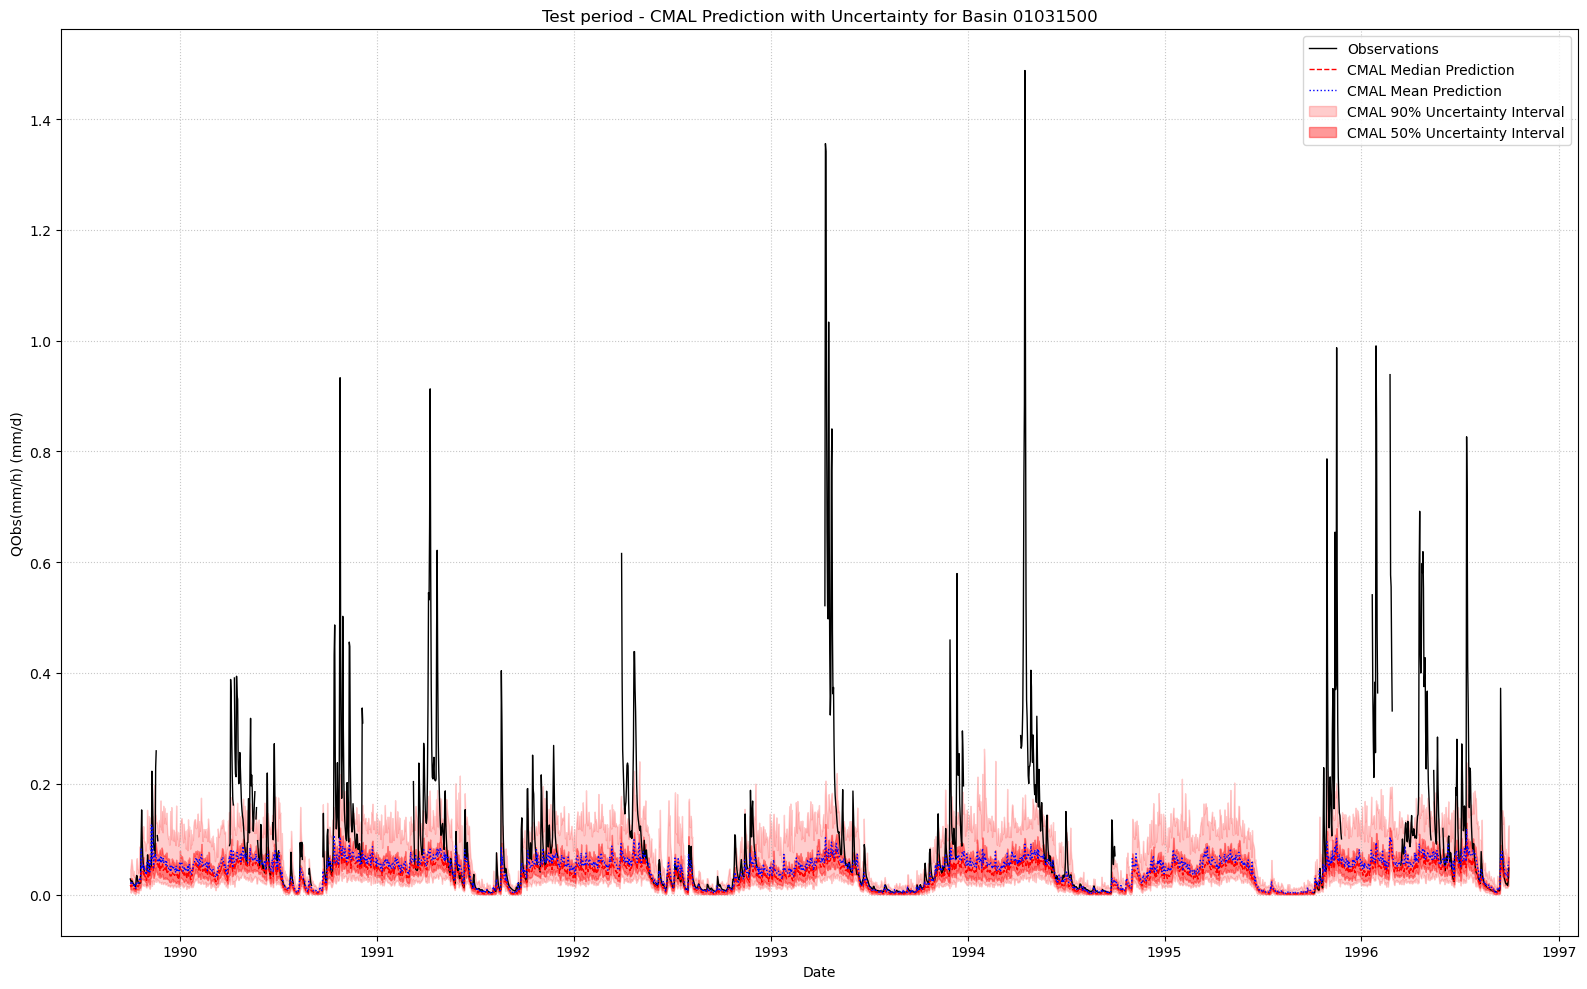

In [16]:
basin_id = '01031500' # Your basin ID
freq = '1D'           # Your frequency key
target_variable = 'QObs(mm/h)' # Your target variable name

# --- 1. Extract Observations ---
# Added .squeeze() here to make qobs a 1D array (removing the time_step dimension)
qobs = results[basin_id][freq]['xr'][f'{target_variable}_obs'].squeeze()

# --- 2. Extract Simulated Output with Samples ---
# This variable contains 100 samples for each time step
qsim_with_samples = results[basin_id][freq]['xr'][f'{target_variable}_sim']

# --- 3. Calculate Quantiles from Samples ---
# Convert the xarray DataArray to a NumPy array for easier percentile calculation.
# The 'samples' dimension is the last one in (date, time_step, samples).
qsim_data = qsim_with_samples.values

# Calculate percentiles across the 'samples' dimension (axis=-1)
# np.nanpercentile handles potential NaN values if present.
median_sim = np.nanpercentile(qsim_data, 50, axis=-1)  # 50th percentile (median)
q25 = np.nanpercentile(qsim_data, 25, axis=-1)         # 25th percentile
q75 = np.nanpercentile(qsim_data, 75, axis=-1)         # 75th percentile
lower_bound_90ci = np.nanpercentile(qsim_data, 5, axis=-1)   # 5th percentile (lower bound of 90% CI)
upper_bound_90ci = np.nanpercentile(qsim_data, 95, axis=-1) # 95th percentile (upper bound of 90% CI)
mean_sim = np.nanmean(qsim_data, axis=-1) # Use np.nanmean to handle NaNs

# Convert the percentile arrays back to xarray DataArray to retain 'date' coordinates
# Now, qobs.copy() will create a 1D xarray.DataArray, and median_sim.squeeze() is also 1D,
# so their shapes will match.
median_sim = qobs.copy(data=median_sim.squeeze())
q25 = qobs.copy(data=q25.squeeze())
q75 = qobs.copy(data=q75.squeeze())
lower_bound_90ci = qobs.copy(data=lower_bound_90ci.squeeze())
upper_bound_90ci = qobs.copy(data=upper_bound_90ci.squeeze())
mean_sim = qobs.copy(data=mean_sim.squeeze())

# --- 4. Plotting with Seaborn for Uncertainty ---
fig, ax = plt.subplots(figsize=(16, 10))

# Plot observations
ax.plot(qobs['date'], qobs.values, color='black', label='Observations', linewidth=1)

# Plot median prediction
ax.plot(median_sim['date'], median_sim.values, color='red', linestyle='--', label='CMAL Median Prediction', linewidth=1)
ax.plot(mean_sim['date'], mean_sim.values, color='blue', linestyle=':', label='CMAL Mean Prediction', linewidth=1)

# Plot uncertainty bands using fill_between
# 90% Confidence Interval (between 5th and 95th percentiles)
ax.fill_between(
    lower_bound_90ci['date'].values,
    lower_bound_90ci.values,
    upper_bound_90ci.values,
    color='red',
    alpha=0.2, # Lighter transparency for the wider band
    label='CMAL 90% Uncertainty Interval'
)

# 50% Confidence Interval (between 25th and 75th percentiles)
ax.fill_between(
    q25['date'].values,
    q25.values,
    q75.values,
    color='red',
    alpha=0.4, # Darker transparency for the narrower band
    label='CMAL 50% Uncertainty Interval'
)

ax.set_ylabel(f"{target_variable} (mm/d)")
ax.set_xlabel("Date")
ax.set_title(f"Test period - CMAL Prediction with Uncertainty for Basin {basin_id}")
ax.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Calculate all metrics for the median prediction
values = metrics.calculate_all_metrics(qobs, mean_sim)

# Print the calculated metrics
print("\nMetrics for CMAL Median Prediction:")
for key, val in values.items():
    print(f"{key}: {val:.3f}")


Metrics for CMAL Median Prediction:
NSE: 0.029
MSE: 0.023
RMSE: 0.150
KGE: -0.078
Alpha-NSE: 0.175
Beta-KGE: 0.413
Beta-NSE: -0.401
Pearson-r: 0.629
FHV: -88.444
FMS: -39.521
FLV: -18.839
Peak-Timing: 0.167
Peak-MAPE: 87.573
